In [12]:
import pandas as pd
import numpy as np
from datetime import datetime
import yfinance as yf
from dateutil.relativedelta import relativedelta
import itertools
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

In [24]:
import sys
from pathlib import Path

project_root = Path.cwd().parents[0]  # adjust if needed
sys.path.append(str(project_root))

from src.portfolio.tickers import *

In [25]:
print("yfinance version:", yf.__version__)

yfinance version: 0.2.66


# Abstract

We will be backtesting Ray Dalio's All-Weather Asset Allocation against the University Portfolios
* Link: https://www.optimizedportfolio.com/all-weather-portfolio/
* Link: https://andrewcharlesjones.github.io/journal/universal-portfolios.html

# Global Vars

In [26]:
DT_FORMAT = '%Y-%m-%d'

# Config

In [27]:
DATE_START = '2021-01-01'
DATE_END = ( datetime.today() + relativedelta(days=-1) ).strftime(DT_FORMAT)

# Get Data

### Pull Tickers

In [121]:
etf_tickers = [x for x in ETFS.split('\n') if len(x) > 0]
tec_tickers = [x for x in TEC_EQ.split('\n') if len(x) > 0]
fs_tickers = [x for x in FS_EQ.split('\n') if len(x) > 0]
phm_tickers = [x for x in PHM_EQ.split('\n') if len(x) > 0]

tickers = etf_tickers + tec_tickers + fs_tickers + phm_tickers

In [122]:
df_ticker = yf.download(
    ' '.join(tickers),
    start=DATE_START,
    end=DATE_END,
    auto_adjust=True,
)

c:\Users\sohnn\Documents\Stock Portfolio Mgmt\Trading-Strategies-Deployment\venv\Lib\site-packages\yfinance\scrapers\history.py:204: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.
  dt_now = pd.Timestamp.utcnow()
c:\Users\sohnn\Documents\Stock Portfolio Mgmt\Trading-Strategies-Deployment\venv\Lib\site-packages\yfinance\scrapers\history.py:204: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.
  dt_now = pd.Timestamp.utcnow()
c:\Users\sohnn\Documents\Stock Portfolio Mgmt\Trading-Strategies-Deployment\venv\Lib\site-packages\yfinance\scrapers\history.py:204: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.
  dt_now = pd.Timestamp.utcnow()
c:\Users\sohnn\Documents\Stock Portfolio Mgmt\Trading-Strategies-Deployment\venv\Lib\site-packages\yfinance\scrapers\history.py:204: Pan

In [140]:
prices = df_ticker['Close'].values
returns = (prices[1:]/prices[:-1]-1)
tickers_pulled = df_ticker['Close'].columns
dates_pulled = df_ticker.index[1:]

# Visualize Returns

In [168]:
def plot_returns(dates, tickers, returns, tickers_sel, title='') -> None:

    plt.figure(figsize=(10, 6), dpi=80, edgecolor='k')
    for ticker in tickers_sel:
        ticker_index = np.where(tickers == ticker)[0][0]
        viz_cume_returns = ( np.cumprod(returns[:, ticker_index]+1) - 1) * 100
        plt.plot(dates, viz_cume_returns, label=ticker)
    plt.plot(dates_pulled, [0]*len(dates_pulled), color='k', linestyle='--')

    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Cume Returns (%)')
    plt.title('Historical returns: ' + title)
    plt.show()

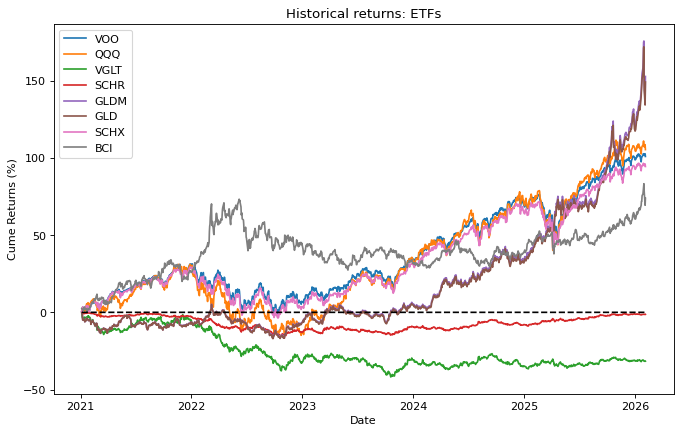

In [169]:
plot_returns(dates_pulled, tickers_pulled, returns, etf_tickers, 'ETFs')

# Portfolio Allocation Strategy Backtest

In [151]:
'''
    Initialize N Random Portfolios of weights (w) across the M assets, where w is a vector of length M and sum(w) = 1
'''

T_days, m_assets = returns.shape

# generate starting portfolio allocations
n_portfolios = 10_000
k_stocks_per_portfolio = 10

def generate_random_portfolios(m_assets, n_portfolios=10_000, k_stocks_per_portfolio=10):
    portfolios = []
    for _ in range(n_portfolios):
        k = np.random.randint(1, k_stocks_per_portfolio) # generate random of between 1 through n_stocks_per_portfolio stocks
        w = np.zeros(m_assets)
        idx = np.random.choice(m_assets, k, replace=False) # randomly select k stocks to choose
        w[idx] = np.random.rand(k) # randomly assign weights to the selected stocks
        w /= w.sum() # normalize weights to sum to 1
        portfolios.append(w)
    portfolios = np.array(portfolios)
    return portfolios

portfolios = generate_random_portfolios(m_assets, n_portfolios, k_stocks_per_portfolio)

In [156]:
# each starting portfolio (fixed alloc) will start off with $1
wealth = np.ones(len(portfolios))

# portfolio weights / distributions at any given point in time
alloc_history = []
for t in range(T_days):

    # allocation for a given period is based on the  wealth of each portfolio eod yesterday (which has a fixed set of alloc across assets)
    alloc_t = np.average(portfolios, axis=0, weights=wealth)

    alloc_history.append(alloc_t)

    # dot product the portfolio's wealth
    wealth *= np.dot(portfolios, (returns[t]+1)) # determines the wealth of each portfolio based on the returns of the assets and the fixed allocation of each portfolio

alloc_history = np.array(alloc_history)

In [157]:
T, N = returns.shape

portfolio_returns = np.sum(alloc_history * returns, axis=1)
portfolio_growth = (1 + portfolio_returns).cumprod()

df_alloc_history = pd.DataFrame(alloc_history, columns=tickers_pulled)
df_alloc_history['portfolio_returns'] = portfolio_returns
df_alloc_history['portfolio_growth'] = portfolio_growth - 1
df_alloc_history['date'] = dates_pulled

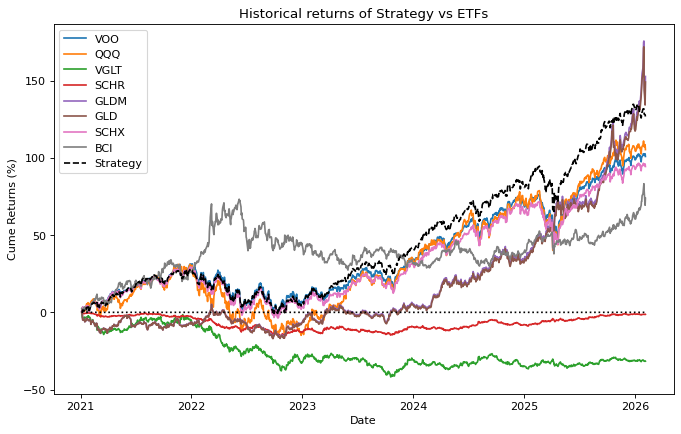

In [166]:
plt.figure(figsize=(10, 6), dpi=80, edgecolor='k')
for ticker in etf_tickers:
    ticker_index = np.where(tickers_pulled == ticker)[0][0]
    viz_cume_returns = ( np.cumprod(returns[:, ticker_index]+ 1) - 1 ) * 100
    plt.plot(dates_pulled, viz_cume_returns, label=ticker)
plt.plot(dates_pulled, [0]*len(dates_pulled), color='k', linestyle=':')
plt.plot(df_alloc_history['date'], df_alloc_history['portfolio_growth']*100, label='Strategy', color='k', linestyle='--')

plt.legend()
plt.xlabel('Date')
plt.ylabel('Cume Returns (%)')
plt.title('Historical returns of Strategy vs ETFs')
plt.show()

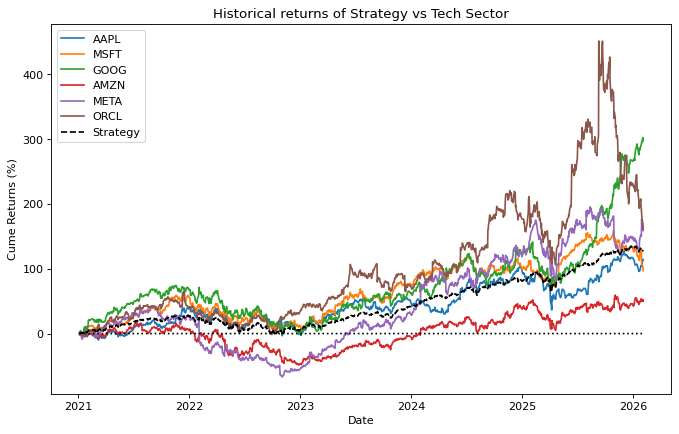

In [167]:
plt.figure(figsize=(10, 6), dpi=80, edgecolor='k')
for ticker in tec_tickers:
    ticker_index = np.where(tickers_pulled == ticker)[0][0]
    viz_cume_returns = ( np.cumprod(returns[:, ticker_index]+1)-1 ) * 100
    plt.plot(dates_pulled, viz_cume_returns, label=ticker)
plt.plot(dates_pulled, [0]*len(dates_pulled), color='k', linestyle=':')
plt.plot(df_alloc_history['date'], df_alloc_history['portfolio_growth']*100, label='Strategy', color='k', linestyle='--')

plt.legend()
plt.xlabel('Date')
plt.ylabel('Cume Returns (%)')
plt.title('Historical returns of Strategy vs Tech Sector')
plt.show()

# Backtesting UPT with Constrained Cash Flow Execution

In [181]:
V0 = 10_000
WC = 100

In [ ]:
min_dt = min(dates_pulled)
max_dt = max(dates_pulled)

tuesdays = pd.date_range(
    start=min_dt,
    end=max_dt,
    freq="W-TUE"
)

# make it NOT inclusive
tuesdays = tuesdays[(tuesdays > min_dt) & (tuesdays < max_dt)]

In [186]:
tuesdays

DatetimeIndex(['2021-01-12', '2021-01-19', '2021-01-26', '2021-02-02',
               '2021-02-09', '2021-02-16', '2021-02-23', '2021-03-02',
               '2021-03-09', '2021-03-16',
               ...
               '2025-11-25', '2025-12-02', '2025-12-09', '2025-12-16',
               '2025-12-23', '2025-12-30', '2026-01-06', '2026-01-13',
               '2026-01-20', '2026-01-27'],
              dtype='datetime64[s]', length=264, freq='W-TUE')

In [ ]:
dates_pulled
alloc_history

DatetimeIndex(['2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-11', '2021-01-12', '2021-01-13', '2021-01-14',
               '2021-01-15', '2021-01-19',
               ...
               '2026-01-21', '2026-01-22', '2026-01-23', '2026-01-26',
               '2026-01-27', '2026-01-28', '2026-01-29', '2026-01-30',
               '2026-02-02', '2026-02-03'],
              dtype='datetime64[s]', name='Date', length=1276, freq=None)